In [1]:
'''
This version uses a google trend finding data function that 
returns daily observations. However, it can only retrieve data up to
four days in the past.
'''

'\nThis version uses a google trend finding data function that \nreturns daily observations. However, it can only retrieve data up to\nfour days in the past.\n'

In [2]:
import pandas as pd
import numpy as np
import re
from pytrends import dailydata
from datetime import datetime, date

import yfinance as yf

from prophet import Prophet
from prophet.plot import add_changepoints_to_plot, plot_cross_validation_metric
from prophet.diagnostics import cross_validation, performance_metrics

import matplotlib.pyplot as plt
import plotly.graph_objs as go #veremos si puedo ocupar otro paquete

# TimeFrame, Split, and N Days into the Future

In [3]:
# Splitting de dataframe for training and testing
start_date = '2022-06-01'
end_date = '2023-02-28'
split = '2022-11-01' #Splitting today means model will train with data up to today
d_future = 0

# Choosing Google searches as exogenous regressors
kw_list = [
           'buy bitcoin', 
           #'how to buy bitcoin', 
           #'is bitcoin dead', 
           #'will bitcoin crash',
          ]

# Setting the data

In [4]:
# Downloading Bitcoin data
data = yf.download(tickers = 'BTC-USD',
                  start = start_date,
                  end = end_date,
                  interval = '1d')

# Reseting the index to have date as a column
data = data.reset_index()

# Setting date format
data['Date'] = pd.to_datetime(data['Date'])

# Changing variable upper cases
dict_cols = {
    'Date': 'date',
    'Open': 'open',
    'High': 'high',
    'Low': 'low',
    'Close': 'close',
    'Adj Close': 'adj_close',
    'Volume': 'volume'
}

cols = [['date', 'open', 'high', 'low', 'close', 'ad_close', 'volume']]
data = data.rename(columns = dict_cols)

data.head()

[*********************100%***********************]  1 of 1 completed


,date,open,high,low,close,adj_close,volume
0,2022-06-01,31792.554688,31957.285156,29501.587891,29799.080078,29799.080078,41135817341
1,2022-06-02,29794.890625,30604.734375,29652.705078,30467.488281,30467.488281,29083562061
2,2022-06-03,30467.806641,30633.035156,29375.689453,29704.390625,29704.390625,26175547452
3,2022-06-04,29706.138672,29930.564453,29500.005859,29832.914062,29832.914062,16588370958
4,2022-06-05,29835.117188,30117.744141,29574.449219,29906.662109,29906.662109,17264085441


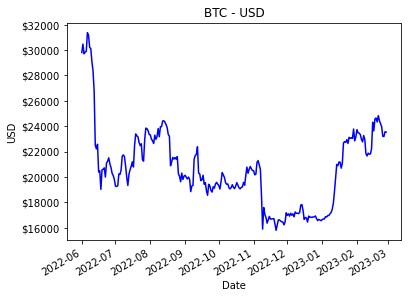

In [5]:
# Plotting the time series

fig, ax = plt.subplots()

plt.plot(data.date,data.close, color = 'blue') #se pueden agregar más series
#plt.plot(data.date,data.high, color = 'r')

plt.title('BTC - USD')

plt.xticks(rotation=30, ha='right')
plt.xlabel('Date')
plt.ylabel('USD')

ax.yaxis.set_major_formatter('${x:1.0f}')

ax.yaxis.set_tick_params(which='major', labelcolor='black',
                         labelleft= True, labelright= False)

plt.show()

In [6]:
# Keeping only certain columns to work on

df = data.drop(['open', 'high', 'low', 'adj_close', 'volume'],
               axis = 1)

# Renaming again to work with Prophet
df = df.rename(columns = {'date': 'ds', 'close': 'y'})

df.head()

,ds,y
0,2022-06-01,29799.080078
1,2022-06-02,30467.488281
2,2022-06-03,29704.390625
3,2022-06-04,29832.914062
4,2022-06-05,29906.662109


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 272 entries, 0 to 271
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      272 non-null    datetime64[ns]
 1   y       272 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 4.4 KB


# Split Date and Days to forecast in the future

In [8]:
#Splitting dataframe

df_train = df.query('ds < @split')
df_test = df.query('ds >= @split')

print('Testing data has', len(df_test), 'observations') 
print('Traning data has', len(df_train), 'observations') 

Testing data has 119 observations
Traning data has 153 observations


In [9]:
split_date = datetime.strptime(split, "%Y-%m-%d")
split_date
delta = df.ds.max() - split_date
delta.days

118

# Setting the model

In [10]:
%%time

# Creating the model, setting a confidence interval of 95% (default is 80%)
# We keep yearly seasonality False because of low n. Daily too bc no data within days.
model = Prophet(interval_width = 0.95, 
                yearly_seasonality = False,
                daily_seasonality = False)


# Fitting the model
model.fit(df_train)

Wall time: 1.81 s


C:\Users\alfre\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


In [11]:
# Create a future dataframe (supressing the need for testing df?)
df_future = model.make_future_dataframe(periods = (delta.days + d_future)) #In what moment was frequency setted?

# Making forecast (or technically, prediction)
df_forecast = model.predict(df_future)

df_forecast.tail()

C:\Users\alfre\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\alfre\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
266,2023-02-22,18893.176767,-3018.700611,41189.286296,-2520.856231,41723.053174,-24.599311,-24.599311,-24.599311,-24.599311,-24.599311,-24.599311,0.0,0.0,0.0,18868.577455
267,2023-02-23,18888.229936,-3327.736184,41809.924446,-2767.154828,41788.876540,119.170005,119.170005,119.170005,119.170005,119.170005,119.170005,0.0,0.0,0.0,19007.399941
268,2023-02-24,18883.283106,-2709.072127,41225.593278,-3013.369246,41981.904961,45.189458,45.189458,45.189458,45.189458,45.189458,45.189458,0.0,0.0,0.0,18928.472563
269,2023-02-25,18878.336275,-3929.424525,43057.095586,-3259.583663,42466.192485,20.278884,20.278884,20.278884,20.278884,20.278884,20.278884,0.0,0.0,0.0,18898.615159
270,2023-02-26,18873.389444,-3587.824267,42450.578013,-3505.798080,42947.541715,-10.628683,-10.628683,-10.628683,-10.628683,-10.628683,-10.628683,0.0,0.0,0.0,18862.760762


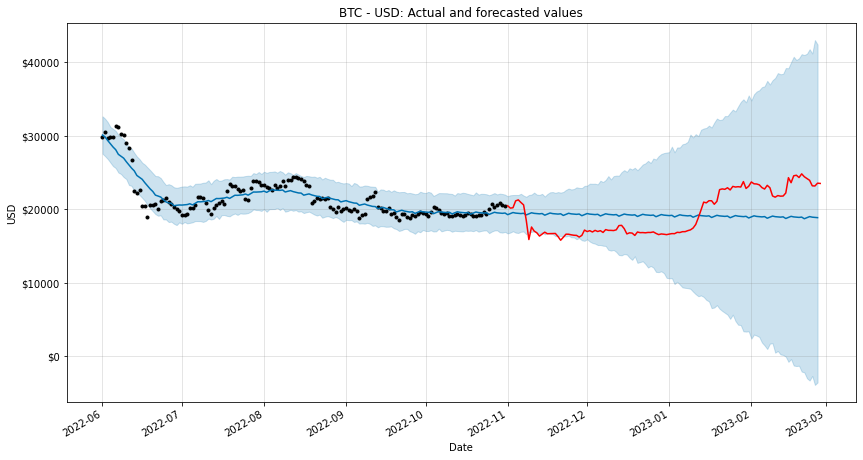

'\n# Another way to visualize the forecast\nfig = model.plot(df_forecast)\nax = fig.gca()\nax.plot(df_test["ds"], df_test["y"], \'b.\')\n'

In [12]:
# import seaborn as sns
#color_pal = sns.color_palette('dark')

fig, ax = plt.subplots(figsize=(12,6))
fig = model.plot(df_forecast,
                ax = ax,
                uncertainty = True)
ax.plot(df_test["ds"], df_test["y"], color = 'r')

plt.title('BTC - USD: Actual and forecasted values')

plt.xticks(rotation=30, ha='right')
plt.xlabel('Date')
plt.ylabel('USD')

ax.yaxis.set_major_formatter('${x:1.0f}')

ax.yaxis.set_tick_params(which='major', labelcolor='black',
                         labelleft= True, labelright= False)

plt.show()

'''
# Another way to visualize the forecast
fig = model.plot(df_forecast)
ax = fig.gca()
ax.plot(df_test["ds"], df_test["y"], 'b.')
'''

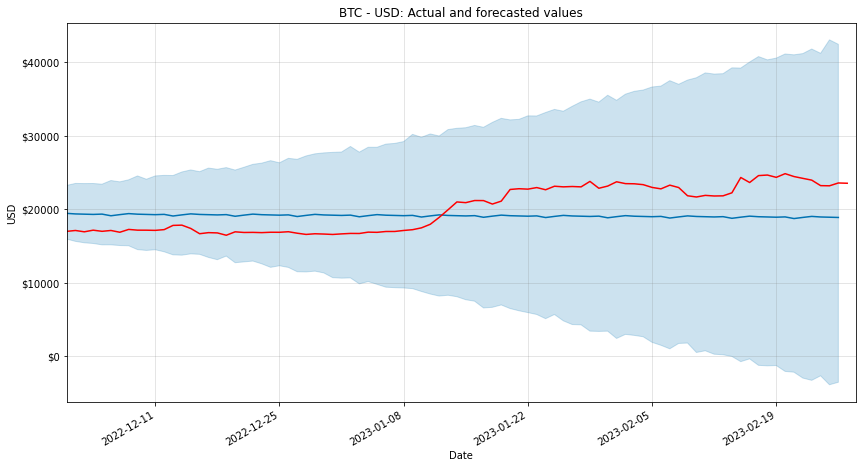

In [13]:
# Zooming ing
#plt.close()

fig, ax = plt.subplots(figsize=(12,6))
fig = model.plot(df_forecast,
                ax = ax,
                uncertainty = True)
ax.plot(df_test["ds"], df_test["y"], color = 'r')

plt.title('BTC - USD: Actual and forecasted values')

plt.xticks(rotation=30, ha='right')
plt.xlabel('Date')
plt.ylabel('USD')

ax.yaxis.set_major_formatter('${x:1.0f}')

ax.yaxis.set_tick_params(which='major', labelcolor='black',
                         labelleft= True, labelright= False)
ax.set_xlim(datetime.strptime('2022-12-01', "%Y-%m-%d"), 
            datetime.strptime(end_date, "%Y-%m-%d")
           )

plt.show()

# Ojo que 

# Time Series Decomposing

C:\Users\alfre\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


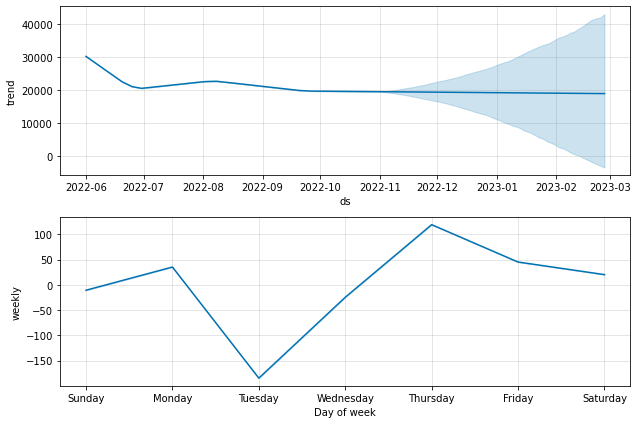

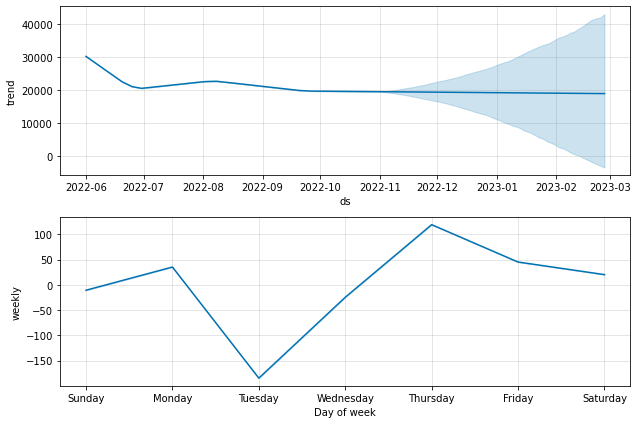

In [14]:
#Visualizing components
model.plot_components(df_forecast)

# Identifying changing points

There are 25 change points. 
The change points dates are 
            ds             y
5   2022-06-06  31370.671875
10  2022-06-11  28360.810547
15  2022-06-16  20381.650391
19  2022-06-20  20599.537109
24  2022-06-25  21502.337891
29  2022-06-30  19784.726562
34  2022-07-05  20190.115234
39  2022-07-10  20860.449219
44  2022-07-15  20836.328125
48  2022-07-19  23389.433594
53  2022-07-24  22609.164062
58  2022-07-29  23804.632812
63  2022-08-03  22846.507812
68  2022-08-08  23809.486328
73  2022-08-13  24424.068359
77  2022-08-17  23335.998047
82  2022-08-22  21398.908203
87  2022-08-27  20041.738281
92  2022-09-01  20127.140625
97  2022-09-06  18837.667969
102 2022-09-11  21769.255859
106 2022-09-15  19701.210938
111 2022-09-20  18890.789062
116 2022-09-25  18802.097656
121 2022-09-30  19431.789062


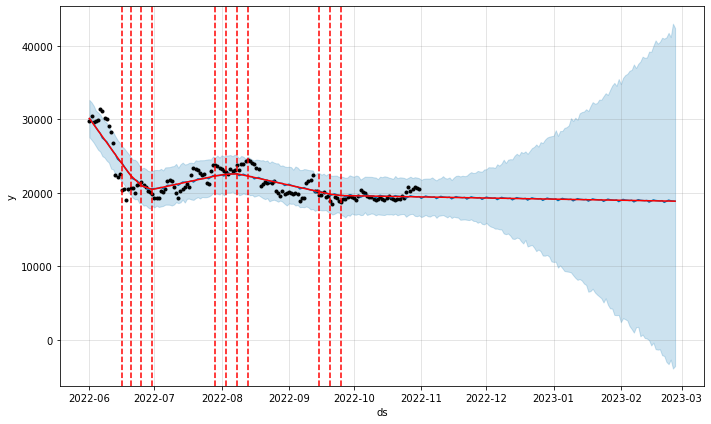

In [15]:
# Default change points
print(f'There are {len(model.changepoints)} change points. \nThe change points dates are \n{df.loc[df["ds"].isin(model.changepoints)]}')

# Change points to plot
fig = model.plot(df_forecast)
a = add_changepoints_to_plot(fig.gca(), model, df_forecast)
plt.show()

# Adding exogenous regressors to dataframe

In [16]:
# Getting searches
from helper import get_searches, add_underscore, drop_nans

df_searches = get_searches(kw_list, start_date, end_date)

# Merging searches with original BTC dataframe
df_searches = df_searches.reset_index()
df_searches = df_searches.rename(columns = {'index': 'ds'})
df_ex = pd.merge(df, df_searches, how = 'left', on = 'ds')
df_ex.head()

The request failed: Google returned a response with code 429
Trying again in 60 seconds.


KeyboardInterrupt: 

In [ ]:
df_ex.shape

In [ ]:
# Locating and eliminating NANs
# Prophet doesn't need evenly spaced data

df_ex = drop_nans(df_ex)

In [ ]:
df_ex.tail()

In [ ]:
# Checking correlation
df_ex.corr()['y']

In [ ]:
# Splitting dataframe

df_train_ex = df_ex.query('ds < @split')
df_test_ex = df_ex.query('ds >= @split')

print('Testing data has', len(df_test_ex), 'observations') 
print('Training data has', len(df_train_ex), 'observations') 

# Setting model with exogenous variables

In [ ]:
%%time

# Creating the model, setting a confidence interval of 95% (default is 80%)
# We keep yearly seasonality False because of low n. Daily too bc no data within days.
model_ex = Prophet(interval_width = 0.95, 
                   yearly_seasonality = False,
                   daily_seasonality = False)


# Adding exogenous regressors:

for kw in kw_list:
    kw_underscore = re.sub('\ ', '_', kw)
    model_ex.add_regressor(kw_underscore, mode="additive")

# Fitting the model
model_ex.fit(df_train_ex)

# Create a future dataframe (supressing the need for testing df?)
df_future_ex = model_ex.make_future_dataframe(periods = (delta.days + d_future)) #In what moment was frequency setted?

'''
# Adding column with exogenous variable name in future dataframe
for kw in kw_list:
    import re
    kw_underscore = re.sub('\ ', '_', kw)
    df_future_ex = df_future_ex.reindex(columns = df_future_ex.columns.tolist() + [kw_underscore])
'''
# Ok. Ahora nuestro df_future no hace forecasting. Solo predicción.
# Ahora le agregamos los valores de "buy_bitcoin" al df de predicción:
df_future_ex = pd.merge(df_future_ex, df_ex, how = 'left', on = 'ds')

# PROBLEMA: Si ponemos una fecha en que no existen datos para últimos días en df_ex, del merge 
# se tendrá un df_future_ex que también tendrá NaN's en sus últimos días.
# SOLUCIÓN: Traquear y eliminar los NaNs acá. No sé si se puede entrenar el 
# modelo con nan's y  por lo tanto suprimir la eliminación de NaN's anterior.
# Si también se tiene que hacer antes, lo recomendable es definir una función.

df_future_ex = drop_nans(df_future_ex)

In [ ]:
# Making forecast (or technically, prediction)
df_forecast_ex = model_ex.predict(df_future_ex)

In [ ]:
plt.close()

fig, ax = plt.subplots(figsize=(12,6))
fig = model_ex.plot(df_forecast_ex,
                ax = ax,
                uncertainty = True)
ax.plot(df_test_ex["ds"], df_test["y"], color = 'r')

plt.title('BTC - USD: Actual and forecasted values')

plt.xticks(rotation=30, ha='right')
plt.xlabel('Date')
plt.ylabel('USD')

ax.yaxis.set_major_formatter('${x:1.0f}')

ax.yaxis.set_tick_params(which='major', labelcolor='black',
                         labelleft= True, labelright= False)

ax.set_ylim((df_ex.y.min() - 2000), (df_ex.y.max() + 2000))

plt.show()

In [ ]:
# Is making the date frame shorter better for adjustment?
# Moreover, adding some keywords seem to worsen the prediction capabilities.